In [1]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn import linear_model, metrics, datasets # linear_model - модуль в котором LinearRegression
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.pipeline import make_pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols, logit

**Вытаскиваем нужный dataset из sklearn**

* `as_frame=True` - dataset сразу в DF
* `return_X_y=True` - возвращает готовые Признаки и Целевую


In [2]:
X, Y = datasets.load_diabetes(as_frame=True, return_X_y=True)

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


*Модель Линейной Регрессии*

In [ ]:
# model_class = linear_model.LinearRegression

In [4]:

X_test.shape
X_train.shape

(331, 10)

In [30]:
# FIXME StandardScaler  1
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test = scaler.transform(X_test)

**ВЫБИРАЕМ Наиболее Качественную Модель:**

*Перебором параметра alpha*

*РЕГУЛЯРИЗАЦИЯ*
* `alpha` - сила влияния регуляризации
* `np.inf` - плюс бесконечность, применяем для инициализации переменной
* `best_alpha` = None - просто неизвестность

In [4]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]

# TODO 1 Прогоняем модели Lasso и Ridge c разными alpha и выбираем наименьший MSE и лучший R2

# model_class_1 = linear_model.Lasso
# model_class_1 = linear_model.Ridge

def get_result_best_hyperparams(model_class_1, X_train, X_test, Y_train, Y_test):
    best_test_mse = np.inf #  инициализация переменной best_test_mse
    best_alpha = None # #  инициализация переменной best_alpha

    for alpha in alphas:
        model_1 = model_class_1(alpha=alpha) # alpha - сила влияния регуляризации
        model_1.fit(X_train, Y_train)
        test_mse = metrics.mean_squared_error(Y_test, model_1.predict(X_test))
# TODO Фильтр Эдисона
        if test_mse < best_test_mse:
            best_test_mse = test_mse  # # переопределяем best_test_mse для фильтра if , записываем наименьшее число
            best_alpha = alpha

    model_1 = model_class_1(alpha=best_alpha)
    model_1.fit(X_train, Y_train)
    Y_train_pred = model_1.predict(X_train)
    Y_test_pred = model_1.predict(X_test)
    train_mse = metrics.mean_squared_error(Y_train, Y_train_pred)
    test_mse = metrics.mean_squared_error(Y_test, Y_test_pred)
    train_r2 = metrics.r2_score(Y_train, Y_train_pred)
    test_r2 = metrics.r2_score(Y_test, Y_test_pred)
    print(f"Train MSE: {train_mse:.3}")
    print(f"Test MSE: {test_mse:.3}")
    print(f"Train R2: {train_r2:.3}")
    print(f"Test R2: {test_r2:.3}")
    return model_1, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2
    # return model, train_mse, test_mse, train_r2, test_r2
get_result_best_hyperparams(linear_model.Lasso, X_train, X_test, Y_train, Y_test)

Train MSE: 2.96e+03
Test MSE: 2.69e+03
Train R2: 0.512
Test R2: 0.513


(Lasso(alpha=0.05),
 array([180.77029607, 203.58340792, 177.82453431, 210.88002813,
        194.07990163, 171.78961737, 123.44003054, 116.85241648,
        119.15672428, 153.39387321, 234.37628317, 221.66772972,
        180.29999884, 184.71434056, 210.43783577,  60.52464438,
        100.14966007, 183.78122853, 160.33595219,  79.6704285 ,
         80.32343047, 204.03626251, 163.98886742, 159.42505898,
        144.02471329, 135.54978721,  78.97288521,  63.49180916,
        101.19155889, 181.01166035, 150.66410668, 284.88020181,
         86.28511592, 170.01080077, 179.36069431, 216.46582091,
        165.13459883, 174.75281999, 218.48325249, 184.28459406,
        106.31301277, 143.3635969 ,  97.84525427, 124.45514143,
         77.00131558,  87.35486559, 139.51188168, 272.54979498,
        212.70697331, 145.31990257,  98.2849161 , 172.30451948,
        162.92652358, 141.00720854, 116.63870363, 183.1240162 ,
        220.374752  , 118.15066296, 140.66845598, 229.56073244,
         80.87541215

*Мой Фильтр*

In [46]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]

# TODO 2 Прогоняем модели Lasso и Ridge c разными alpha и выбираем наименьший MSE и лучший R2
# model_class = linear_model.Lasso
model_class = linear_model.Ridge

def get_result_best_hyperparams_(model_class, X_train, X_test, Y_train, Y_test):
    best = {}
    for n, alpha in enumerate(alphas):
        model = model_class(alpha=alpha) # alpha - сила влияния регуляризации
        model.fit(X_train, Y_train)
        test_mse = metrics.mean_squared_error(Y_test, model.predict(X_test))
# TODO Мой фильтр
        best[n] = test_mse
        # best.update({n: test_mse})
        idx = min(best, key=best.get)
        best_alpha = alphas[idx]
    model = model_class(alpha=best_alpha)
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    train_mse = metrics.mean_squared_error(Y_train, Y_train_pred)
    test_mse = metrics.mean_squared_error(Y_test, Y_test_pred)
    train_r2 = metrics.r2_score(Y_train, Y_train_pred)
    test_r2 = metrics.r2_score(Y_test, Y_test_pred)
    print(f"Train MSE: {train_mse:.3}")
    print(f"Test MSE: {test_mse:.3}")
    print(f"Train R2: {train_r2:.3}")
    print(f"Test R2: {test_r2:.3}")
    # return model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2
    # return model, train_mse, test_mse, train_r2, test_r2
    return idx, best
get_result_best_hyperparams(model_class, X_train, X_test, Y_train, Y_test)

Train MSE: 2.82e+03
Test MSE: 3.06e+03
Train R2: 0.502
Test R2: 0.537


(Ridge(alpha=0.005),
 array([161.8695765 ,  64.29973902, 143.44183588, 197.89117374,
        175.68877561, 117.79547579, 151.89200867,  75.79673513,
        230.63387795, 258.82292079, 164.8148594 , 158.46287499,
        141.24630664, 168.26121103, 107.58335711, 149.82252815,
         86.2797094 , 122.60999995, 126.80395729,  90.2505742 ,
        229.84563667, 217.14452793, 169.92957048,  94.84943819,
        205.76558309, 120.40203547, 106.30949628,  93.83428317,
        184.63249165,  76.74769739, 186.49888366, 180.09575298,
        116.53401552, 197.94044167, 169.47493473, 125.16559654,
        233.46003342, 191.72088609, 104.57380026, 131.5561681 ,
         98.31764561, 192.18290645, 204.03616548,  54.3987349 ,
        135.2701726 , 255.58209016, 139.73309136, 134.06898585,
        188.8536921 , 104.873179  , 148.91437371, 202.1228977 ,
         79.27583818,  67.18218033,  94.6183049 , 154.78802141,
        147.58609568, 169.14910388, 257.24605499, 104.75398371,
        109.3317811

In [47]:
alphas = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50]

# TODO Прогоняем модели Lasso и Ridge
# model_class = linear_model.Lasso
model_class = linear_model.Ridge

def get_result_best_hyperparams(model_class, X_train, X_test, Y_train, Y_test):
    x = -np.inf
    # best = {}
    for n, alpha in enumerate(alphas):
        
        model = model_class(alpha=alpha) # alpha - сила влияния регуляризации
        model.fit(X_train, Y_train)
        test_mse = metrics.mean_squared_error(Y_test, model.predict(X_test))
        # idx = filter(min({n: test_mse}, key={n: test_mse}.get))
        idx =  (x := test_mse) if x < test_mse else n
        print(idx)
   
get_result_best_hyperparams(model_class, X_train, X_test, Y_train, Y_test)

3057.5264933740127
1
3059.495873548798
3086.3106311832144
3120.7336819466245
3440.748937653252
3798.233665850168
5165.429397878005
5752.151818546813
6520.626693219487


"------------------------------------------------------------------------------------------------------"

# heatmap признаков
* Смотрим наличие мультиколениарности
* больше 0,9 - уже плохо

<Axes: >

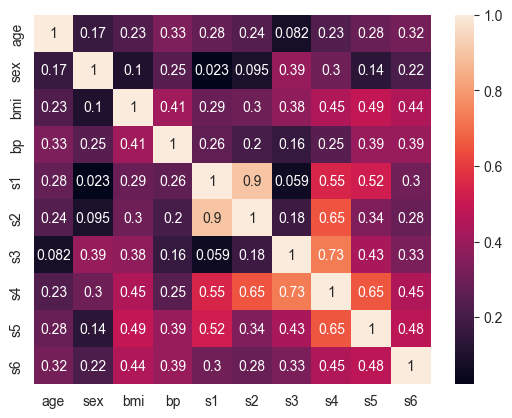

In [8]:
# TODO Строим heatmap по абсолюту, так как смотрим только мультиколлинеарность  
sns.heatmap(np.abs(X_train.corr()), annot=True)


# Нормирование
* get_feature_names_out - получить имена трансформированных признаков

In [10]:
scaler = StandardScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=scaler.get_feature_names_out())
X_test_sc = scaler.transform(X_test)
# X_train_sc



**Метрики MSE и R2 для traine и test Выборок**
* PIPLINE
    * Внутри `pipeline` используется стандартизированный `X_train`
        *  `X_test` подаётся в `model.predict` после обучения модели на стандартизированных `X_train`
    * Снаружи `pipeline` используется исходный `X_train`
* `model.named_steps` - *Имена внутри* `pipeline`

In [12]:
# TODO get_result
def get_result(model_cl, X_train, X_test, Y_train, Y_test):
    # model = model_class()

# TODO Единый блок pipeline с обучением на стандартизированных данных
    model = make_pipeline(StandardScaler(), model_cl()) 
    model.fit(X_train, Y_train)  # Обучение на стандартизированных данных
# TODO Имена внутри pipeline
#     print(model.named_steps)  
# TODO Достаём модель LinearRegression
    linear__model = model.named_steps['linearregression']
    # print(linear__model.coef_)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    train_mse = metrics.mean_squared_error(Y_train, Y_train_pred)
    test_mse = metrics.mean_squared_error(Y_test, Y_test_pred)
    train_r2 = metrics.r2_score(Y_train, Y_train_pred)
    test_r2 = metrics.r2_score(Y_test, Y_test_pred)
    print(f"Train MSE: {train_mse:.3}")
    print(f"Test MSE: {test_mse:.3}")
    print(f"Train R2: {train_r2:.3}")
    print(f"Test R2: {test_r2:.3}")
    return model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2, linear__model
    # return model, train_mse, test_mse, train_r2, test_r2
# get_result(model_class, X_train, X_test, Y_train, Y_test)
# get_result(linear_model.LinearRegression, X_train, X_test, Y_train, Y_test)


**Вызываем ф-цию `get_result()` что бы получить return с вычислениями**

In [105]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2, coefs = get_result(linear_model.LinearRegression, X_train, X_test, Y_train, Y_test)

print('Коэффициенты модели LinearRegression : ', f'{coefs.coef_}')

[ -2.22415219  -8.76006954  22.83535508  13.9175361  -41.86365033
  28.46132134   5.47173405   5.27664091  38.51490159   3.64212309]
Train MSE: 2.81e+03
Test MSE: 3.06e+03
Train R2: 0.503
Test R2: 0.537
Коэффициенты модели LinearRegression :  [ -2.22415219  -8.76006954  22.83535508  13.9175361  -41.86365033
  28.46132134   5.47173405   5.27664091  38.51490159   3.64212309]


# Достаём данные из PIPELINE


In [131]:
# 1. Достаём стандартизатор
scaler = model.named_steps['standardscaler']
print("Средние значения признаков (scaler.mean_):", scaler.mean_)
print("Стандартные отклонения признаков (scaler.scale_):", scaler.scale_)

# 2. Стандартизированные данные
X_train_scaled = scaler.transform(X_train)
print("Форма стандартизированных X_train:", X_train_scaled.shape)

# 3. Достаём модель Ridge
ridge = model.named_steps['linearregression']
print("Коэффициенты Ridge (ridge.coef_):", ridge.coef_)
print("Свободный член (ridge.intercept_):", ridge.intercept_)


Средние значения признаков (scaler.mean_): [ 0.00183832  0.0005714  -0.00166351 -0.00092064  0.00153629  0.00132612
  0.00174093 -0.00038488 -0.00035664  0.00027381]
Стандартные отклонения признаков (scaler.scale_): [0.0476444  0.04759798 0.04656474 0.04743487 0.04879316 0.04915672
 0.04950104 0.04779791 0.04662483 0.04559943]
Форма стандартизированных X_train: (331, 10)
Коэффициенты Ridge (ridge.coef_): [ -2.22415219  -8.76006954  22.83535508  13.9175361  -41.86365033
  28.46132134   5.47173405   5.27664091  38.51490159   3.64212309]
Свободный член (ridge.intercept_): 148.7764350453172


**Создаём словарь для сохранения метрик**

In [108]:
metrics_values = {
    "test_mse": [],
    "test_r2": []
}
model_name = []

In [129]:
# TODO get_result - функция обучает, прогнозирует, вычисляет метрики MSE и R2 для train и test

model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2, coefs = get_result(linear_model.LinearRegression, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
metrics_values["test_r2"].append(test_r2)
model_name.append("LinearRegression")

Train MSE: 2.81e+03
Test MSE: 3.06e+03
Train R2: 0.503
Test R2: 0.537



**Вызываем ф-цию get_result() что бы получить return с вычислениями**

`firs`,`*between`, `last` - Распаковка return функции 
* `firs` и `last` - первый и последний элементы
* `*between` - всё что находится между `firs` и `last`

**Вытаскиваем из PIPELINE функции get_result coef_**

In [13]:

# TODO firs,*between, last - Распаковка return функции 
firs,*_, last = get_result(linear_model.LinearRegression, X_train, X_test, Y_train, Y_test)
last.coef_
# model.named_steps['linearregression'].coef_

Train MSE: 2.51e+03
Test MSE: 3.97e+03
Train R2: 0.554
Test R2: 0.41


array([-2.33240066e-02, -1.22380049e+01,  2.46372409e+01,  1.54160481e+01,
       -4.12381898e+01,  2.27241154e+01,  6.85821542e+00,  7.39496778e+00,
        3.90937763e+01,  3.12038223e+00])

**Строим sns.bar для коэффициентов, смотрим значимость признаков**

In [ ]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2, coefs = get_result(linear_model.LinearRegression, X_train, X_test, Y_train, Y_test)
sns.barplot(abs(coefs.coef_))

*plt.bar*

In [ ]:
plt.bar(X_train_sc.columns, abs(model.coef_))

*Пандосовский bar*

In [ ]:
data=pd.DataFrame(abs(model.coef_))
data.plot(kind='bar')


**Вызываем регулирующие L1 или L2** 
* Смотрим коэффициенты

In [16]:
metrics_values_1 = {
    "test_mse_ridge": [],
    "test_r2_ridge": []
}
model_name_1 = []

**Ridge без Стандартизации Признаков и Признаки Стандартизированы**

In [20]:
# TODO model_ridge без Стандартизации Признаков
model_ridge, Y_train_pred_ridge, Y_test_pred_ridge, train_mse_ridge, test_mse_ridge, train_r2_ridge, test_r2_ridge = get_result_best_hyperparams(linear_model.Ridge, X_train, X_test, Y_train, Y_test)

# TODO model_ridge Признаки Стандартизированы
# model_ridge, Y_train_pred_ridge, Y_test_pred_ridge, train_mse_ridge, test_mse_ridge, train_r2_ridge, test_r2_ridge = get_result_best_hyperparams(linear_model.Ridge, X_train_sc, X_test_sc, Y_train, Y_test)


metrics_values_1["test_mse_ridge"].append(test_mse_ridge)
metrics_values_1["test_r2_ridge"].append(test_r2_ridge)
model_name_1.append("LinearRegression")

model_ridge.coef_

Train MSE: 2.55e+03
Test MSE: 3.95e+03
Train R2: 0.546
Test R2: 0.413


array([  14.72638707, -209.99568184,  478.15761169,  289.72942355,
        -82.67354549, -103.29157106, -178.73833509,   87.53390203,
        458.90609715,   89.240048  ])

**Ridge регрессия с перебором гиперпараметров**

In [6]:
metrics_values = {
    "test_mse": [],
    "test_r2": []
}
model_name = []

In [7]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2 = get_result_best_hyperparams(linear_model.Ridge, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
metrics_values["test_r2"].append(test_r2)
model_name.append("Ridge")
metrics_values

Train MSE: 2.78e+03
Test MSE: 3.27e+03
Train R2: 0.535
Test R2: 0.435


{'test_mse': [3273.2173428430287], 'test_r2': [0.43529242534875223]}

**Lasso регрессия с перебором гиперпараметров**

In [8]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2 = get_result_best_hyperparams(linear_model.Lasso, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
metrics_values["test_r2"].append(test_r2)
model_name.append("Lasso")
metrics_values

Train MSE: 2.79e+03
Test MSE: 3.18e+03
Train R2: 0.532
Test R2: 0.451


{'test_mse': [3273.2173428430287, 3183.8038530084964],
 'test_r2': [0.43529242534875223, 0.4507183716568902]}

**ElasticNet с перебором гиперпараметров**

In [9]:
model, Y_train_pred, Y_test_pred, train_mse, test_mse, train_r2, test_r2 = get_result_best_hyperparams(linear_model.ElasticNet, X_train, X_test, Y_train, Y_test)
metrics_values["test_mse"].append(test_mse)
metrics_values["test_r2"].append(test_r2)
model_name.append("ElasticNet")
metrics_values

Train MSE: 2.81e+03
Test MSE: 3.25e+03
Train R2: 0.53
Test R2: 0.439


{'test_mse': [3273.2173428430287, 3183.8038530084964, 3250.7760177283863],
 'test_r2': [0.43529242534875223, 0.4507183716568902, 0.43916408584363475]}